In [21]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import poly1d
import statsmodels as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

mpl.style.use("seaborn-whitegrid")
mpl.rcParams['figure.figsize'] = (10,2)
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
font = {'family' : 'calibri',
        'size'   : 10}

mpl.rc('font', **font)

Prepare Data

            brent    wti  spread
timestamp                       
03/01/1990  21.69  23.68   -1.99
04/01/1990  21.51  23.41   -1.90
05/01/1990  22.00  23.08   -1.08
08/01/1990  20.52  21.62   -1.10
09/01/1990  20.14  22.07   -1.93
            brent    wti  spread
timestamp                       
03/03/2020  51.86  47.18    4.68
04/03/2020  51.13  46.78    4.35
05/03/2020  49.99  45.90    4.09
06/03/2020  45.27  41.28    3.99
09/03/2020  36.69  33.79    2.90


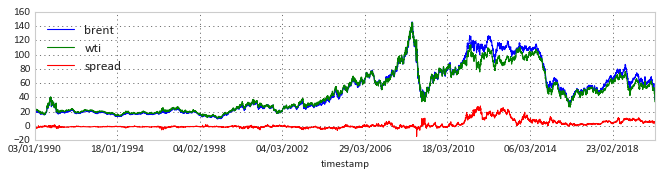

In [22]:
path = "https://github.com/queiyanglim/trading_algorithm/raw/master/oil_trading/data/oil_prices.csv"

df_pull = pd.read_csv(path, header=[0], index_col = 0)
df_pull = df_pull[["CO1 Comdty", "CL1 Comdty"]]
df_pull.index.name = "timestamp"
df_pull = df_pull.rename(columns = {"CO1 Comdty": "brent",
                                    "CL1 Comdty": "wti"})
df_pull
df = df_pull.copy()
df["spread"] = df.brent - df.wti
# df = df.tail(2000)
# df = np.log(df).diff()
df = df.dropna()
/print df.head()
/print df.tail()
df.plot()

In [23]:
# Check Rolling Cointegration
def rolling_coint(df_input,x_name,y_name, update_window):
    roll_p = []
    for i in range(len(df_input) - update_window + 1):
        df = df_input.iloc[i:i + update_window] # Fix window size
        # df = df_input.iloc[:i + update_window] # Update as it goes
        x = df[x_name]
        y = df[y_name]
        coint_res = coint(x.values, y.values)
        p_value = coint_res[1]
        roll_p.append({"timestamp": df.index[-1],
                      "p_value": p_value})
    return pd.DataFrame(roll_p).set_index("timestamp")
    
roll_coint = rolling_coint(df, "wti","brent",300)

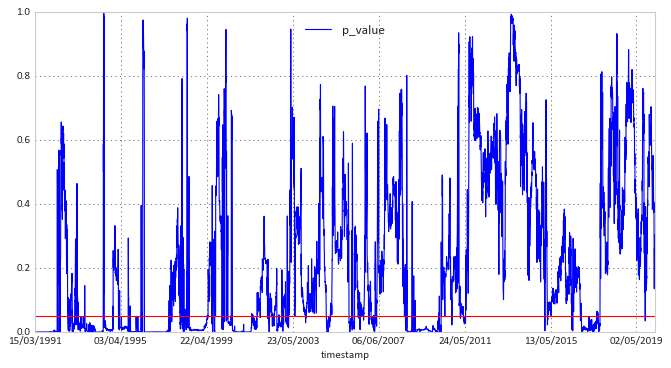

In [24]:
roll_coint.plot(figsize = (10,5))
plt.axhline(0.05, color = "red")

In [25]:
delta = 1e-5
trans_cov = delta / (1 - delta) *np.eye(2)
/print "transition_covriance:"
/print trans_cov

obs_mat = np.vstack([df.wti, np.ones(df.wti.shape)]).T[:,np.newaxis]
/print "observation_matrix"
/print obs_mat

kf = KalmanFilter(n_dim_obs = 1,
                 n_dim_state = 2,
                 initial_state_mean=np.zeros(2),
                 initial_state_covariance=np.ones((2,2)),
                 transition_matrices = np.eye(2),
                 observation_matrices = obs_mat,
                 observation_covariance=1.0,
                 transition_covariance=trans_cov)

#state_means, state_covs = kf.smooth(df.brent.values)
state_means, state_covs = kf.filter(df.brent.values)

transition_covriance:
[[1.00001e-05 0.00000e+00]
 [0.00000e+00 1.00001e-05]]
observation_matrix
[[[23.68  1.  ]]

 [[23.41  1.  ]]

 [[23.08  1.  ]]

 ...

 [[45.9   1.  ]]

 [[41.28  1.  ]]

 [[33.79  1.  ]]]


Shape (7514, 2)


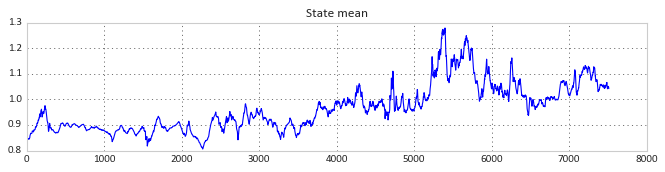

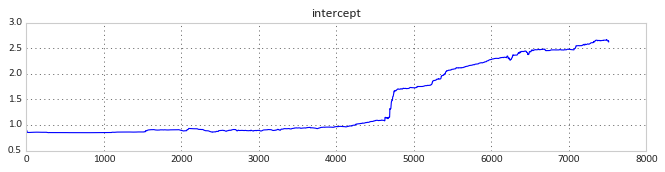

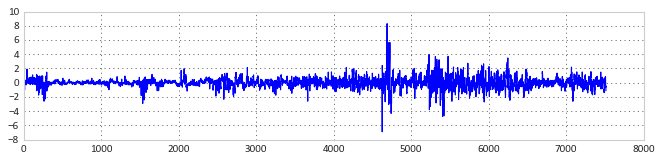

In [26]:
/print "Shape",state_means.shape
plt.plot(state_means[:,0])
plt.title("State mean")
plt.show()
plt.plot(state_means[:,1])
plt.title("intercept")
plt.show()
predict = state_means[:,0] * df.wti.values + state_means[:,1]
plt.plot(df.brent.values - predict)
plt.show()

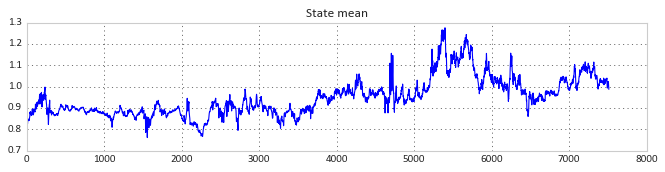

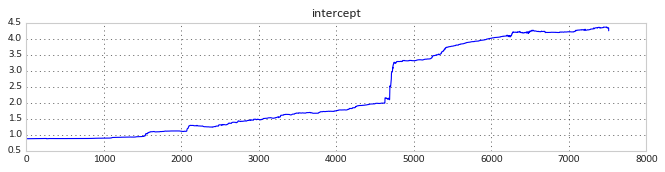

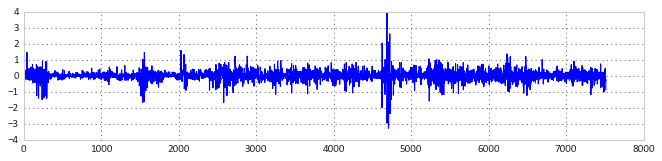

In [27]:
# Expectation Maximization
kf2 = kf.em(df.brent.values, n_iter = 5)
state_means_2, state_covs_2 = kf2.filter(df.brent.values)

state_means.shape
plt.plot(state_means_2[:,0])
plt.title("State mean")
plt.show()
plt.plot(state_means_2[:,1])
plt.title("intercept")
plt.show()
predict = state_means_2[:,0] * df.wti.values + state_means_2[:,1]
plt.plot(df.brent.values - predict)
plt.show()


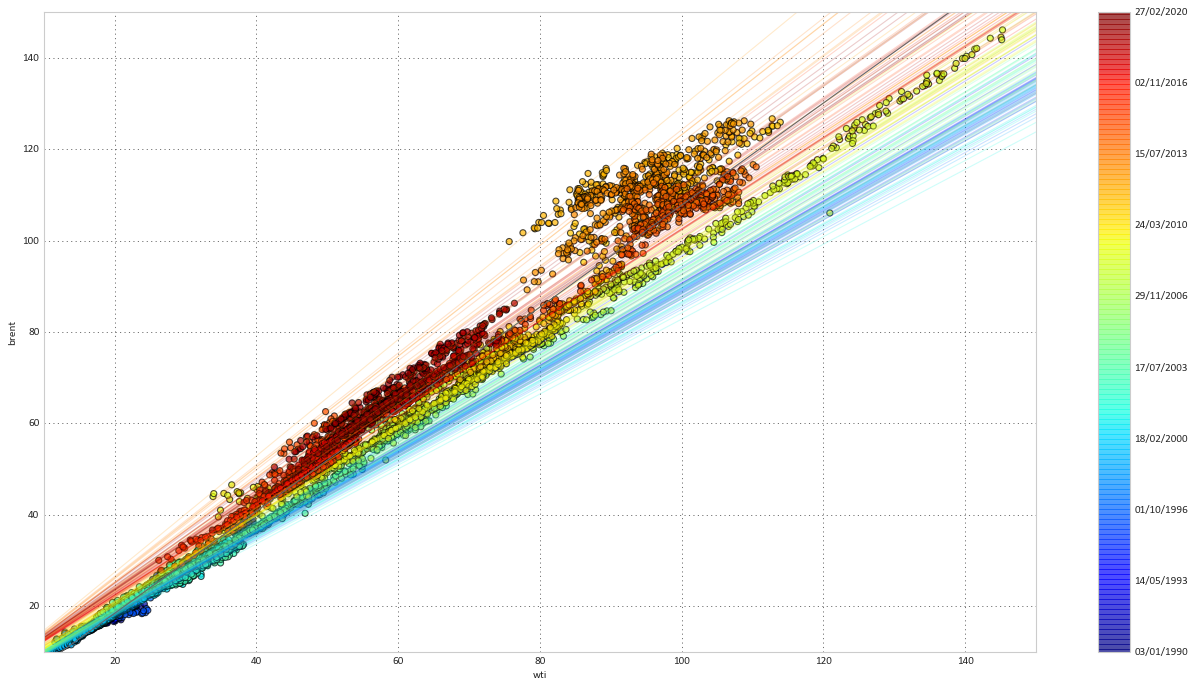

In [28]:
y = df.brent
x = df.wti

fig= plt.figure(figsize=(20,10))
# Plot data points using colormap
colors = np.linspace(0.1, 1, len(x))
cm = plt.get_cmap('jet')
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in x[::len(x)//9].index])

# Plot every fifth line
step = 50
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([10, 150, 10, 150])

# Label axes
plt.xlabel('wti')
plt.ylabel('brent');

In [29]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = add_constant(spread_lag)
    model = OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

def kalman_filter_regression(x, y):
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack([x, np.ones(x.shape)]).T[:,np.newaxis]
    kf = KalmanFilter(n_dim_obs=1, 
                        n_dim_state=2,
                        initial_state_mean=[0,0],
                        initial_state_covariance=np.ones((2, 2)),
                        transition_matrices=np.eye(2),
                        observation_matrices=obs_mat,
                        observation_covariance=2,
                        transition_covariance=trans_cov)
    state_means, state_covs = kf.filter(y.values)
    return state_means

def kalman_filter_average(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

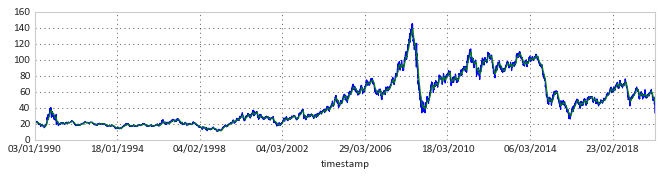

In [30]:
x = df.wti
x1 = kalman_filter_average(x)

x.plot()
x1.plot()

In [47]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate

    x = df[s1]
    y = df[s2]

    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df.index)
    state_means = kalman_filter_regression(kalman_filter_average(x),kalman_filter_average(y))
    #state_means = kalman_filter_regression(x,y)

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    halflife = half_life(df1['spread'])

    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 0

    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'].iloc[0] = 0 

    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'].iloc[0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]

    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name

    days = (end_date - start_date).days

    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)

    df1[s1+ " "+s2] = df1['cum rets']

    return df1, df1[s1+" "+s2], sharpe, CAGR

p, a,b,c = backtest(df,"wti", "brent")

Sharpe:
1.1845237292507838


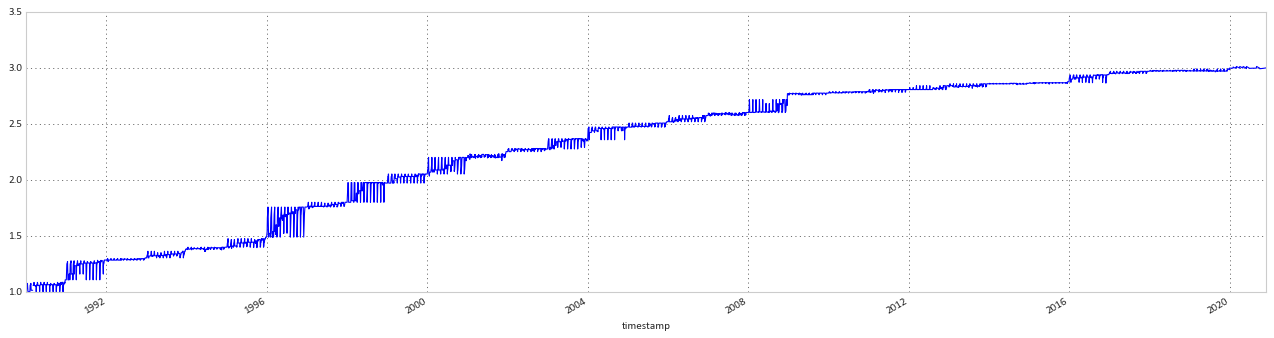

In [48]:
/print "Sharpe:"
/print b
p["cum rets"].plot(figsize = (20,5))